In [5]:
import requests

GAMMA = "https://gamma-api.polymarket.com"

def get_active_markets(limit=100, offset=0):
    params = {
        "active": True,
        "closed": False,
        "limit": limit,
        "offset": offset,
        "order": "endDate",
        "ascending": False,
    }
    r = requests.get(f"{GAMMA}/markets", params=params, timeout=30)
    r.raise_for_status()
    return r.json()

page0 = get_active_markets(limit=100, offset=0)
print(len(page0), page0[0].get("question"), page0[0].get("endDate"))

100 Will Oprah Winfrey win the 2028 Democratic presidential nomination? 2028-11-07T00:00:00Z


In [6]:
page0

[{'id': '559687',
  'question': 'Will Oprah Winfrey win the 2028 Democratic presidential nomination?',
  'conditionId': '0xe06a7e94cf2fa8dc2085b7610fe16e9be1cde6654f34d365c13da1149b276c61',
  'slug': 'will-oprah-winfrey-win-the-2028-democratic-presidential-nomination',
  'resolutionSource': '',
  'endDate': '2028-11-07T00:00:00Z',
  'liquidity': '523926.46958',
  'startDate': '2025-07-11T18:36:32.333Z',
  'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/oprah+winfrey.png',
  'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/oprah+winfrey.png',
  'description': 'This market will resolve to “Yes” if the named individual wins and accepts the 2028 nomination of the Democratic Party for U.S. president. Otherwise, this market will resolve to “No”.\n\nThe resolution source for this market will be a consensus of official Democratic Party sources.\n\nAny replacement of the democratic nominee before election day will not change the resolution of the market.',
  'outcome

In [8]:
import requests

tags = requests.get("https://gamma-api.polymarket.com/tags", params={"limit": 500}, timeout=30).json()

In [9]:
tags

[{'id': '671',
  'label': 'jto',
  'slug': 'jto',
  'publishedAt': '2023-12-07 19:16:45.979+00',
  'createdAt': '2023-12-07T19:16:45.993Z',
  'updatedAt': '2026-02-06T20:01:39.282804Z',
  'requiresTranslation': False},
 {'id': '101592',
  'label': 'Tom Aspinal',
  'slug': 'tom-aspinal',
  'createdAt': '2024-12-31T19:48:27.938591Z',
  'updatedAt': '2026-02-06T20:01:39.296759Z',
  'requiresTranslation': False},
 {'id': '101115',
  'label': 'Preston',
  'slug': 'preston',
  'createdAt': '2024-10-28T20:41:17.828152Z',
  'updatedAt': '2026-02-06T20:01:39.322562Z',
  'requiresTranslation': False},
 {'id': '746',
  'label': 'detroit pistons',
  'slug': 'detroit-pistons',
  'publishedAt': '2023-12-18 18:24:38.687+00',
  'createdAt': '2023-12-18T18:24:38.708Z',
  'updatedAt': '2026-02-06T20:01:39.323344Z',
  'requiresTranslation': False},
 {'id': '1493',
  'label': 'spider-man',
  'slug': 'spider-man',
  'publishedAt': '2024-02-27 19:31:50.152+00',
  'createdAt': '2024-02-27T19:31:50.171Z',
  '

In [11]:
import re
import requests
from typing import Any, Dict, List, Optional, Tuple

GAMMA = "https://gamma-api.polymarket.com"

def _norm(s: str) -> str:
    return re.sub(r"[^a-z0-9]+", "", (s or "").lower())

def list_tags(limit: int = 500) -> List[Dict[str, Any]]:
    # docs: GET /tags (list tags)  [oai_citation:5‡Polymarket](https://docs.polymarket.com/api-reference/tags/list-tags?utm_source=chatgpt.com)
    r = requests.get(f"{GAMMA}/tags", params={"limit": limit}, timeout=30)
    r.raise_for_status()
    return r.json()

def get_tag_by_slug(slug: str) -> Optional[Dict[str, Any]]:
    # docs: GET /tags/slug/{slug}  [oai_citation:6‡Polymarket](https://docs.polymarket.com/api-reference/tags/get-tag-by-slug?utm_source=chatgpt.com)
    r = requests.get(f"{GAMMA}/tags/slug/{slug}", timeout=30)
    if r.status_code == 404:
        return None
    r.raise_for_status()
    return r.json()

def resolve_culture_tag() -> Dict[str, Any]:
    # 1) Try the obvious slugs first (still automated)
    candidate_slugs = [
        "culture",
        "pop-culture",
        "entertainment",
        "celebrities",
        "music",
        "movies",
        "tv",
        "gaming",
    ]
    for slug in candidate_slugs:
        t = get_tag_by_slug(slug)
        if t:
            return t

    # 2) Fallback: fuzzy resolve from ALL tags (not just carousel)
    tags = list_tags(limit=1000)
    target = _norm("culture")

    def score(t: Dict[str, Any]) -> Tuple[int, int, int]:
        label = _norm(t.get("label", ""))
        slug  = _norm(t.get("slug", ""))

        # Match quality
        exact = 1 if (label == target or slug == target) else 0
        contains = 1 if (target in label or target in slug) else 0

        # Prefer UI-ish tags but do NOT require them
        ui = 1 if t.get("isCarousel") else 0
        show = 1 if t.get("forceShow") else 0

        # Return a tuple for sorting (higher is better)
        return (exact, contains, show + ui)

    best = max(tags, key=score, default=None)
    if not best or score(best) == (0, 0, 0):
        raise RuntimeError("Could not resolve Culture tag from Gamma tags.")
    return best

def list_events_for_tag(tag: Dict[str, Any], limit=50, offset=0) -> List[Dict[str, Any]]:
    # docs: GET /events supports tag_id and tag_slug  [oai_citation:7‡Polymarket](https://docs.polymarket.com/api-reference/events/list-events?utm_source=chatgpt.com)
    params = {
        "tag_id": tag["id"],
        "active": True,
        "closed": False,
        "limit": limit,
        "offset": offset,
        "order": "updatedAt",
        "ascending": False,
    }
    r = requests.get(f"{GAMMA}/events", params=params, timeout=30)
    r.raise_for_status()
    return r.json()

# --- Usage ---
culture_tag = resolve_culture_tag()
print("Resolved culture tag:", culture_tag.get("label"), culture_tag.get("slug"), culture_tag.get("id"))

events = list_events_for_tag(culture_tag, limit=50, offset=0)
print("Events:", len(events), "Sample:", events[0].get("title") if events else None)

Resolved culture tag: Culture pop-culture 596
Events: 50 Sample: # of views on Bad Bunny halftime show (YouTube) in week 1?


In [14]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta

# markets can be either:
# 1) a list from Gamma: GET https://gamma-api.polymarket.com/markets  (has endDate as ISO string)  [oai_citation:0‡Polymarket](https://docs.polymarket.com/api-reference/markets/list-markets?utm_source=chatgpt.com)
# 2) a dict like {"data": [...]} (common in some wrappers) -> handled below

def count_ending_within_6mo_not_50_50(markets_obj) -> int:
    # normalize input
    markets = markets_obj.get("data", markets_obj) if isinstance(markets_obj, dict) else markets_obj

    now = datetime.now(timezone.utc)
    cutoff = now + relativedelta(months=+6)

    def parse_end(m):
        # Gamma uses "endDate" ISO strings (example in docs).  [oai_citation:1‡Polymarket](https://docs.polymarket.com/api-reference/markets/list-markets?utm_source=chatgpt.com)
        s = m.get("endDate") or m.get("end_date_iso") or m.get("endDateIso")
        if not s:
            return None
        # handle trailing Z
        if isinstance(s, str) and s.endswith("Z"):
            s = s[:-1] + "+00:00"
        try:
            return datetime.fromisoformat(s).astimezone(timezone.utc)
        except Exception:
            return None

    def is_fifty_fifty(m):
        # Field commonly appears as is_50_50_outcome / similar in Polymarket market objects.  [oai_citation:2‡JSR](https://jsr.io/%40dicedhq/polymarket?utm_source=chatgpt.com)
        return bool(m.get("is_50_50_outcome") or m.get("is50_50_outcome") or m.get("is50-50Outcome"))

    count = 0
    for m in markets:
        if is_fifty_fifty(m):
            continue
        end_dt = parse_end(m)
        if end_dt is None:
            continue
        if now <= end_dt <= cutoff:
            count += 1

    return count

# usage:
markets = client.get_markets()  # whatever you already pulled
print(count_ending_within_6mo_not_50_50(markets))

0


In [15]:
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta

def diag_6mo(markets_obj, n=5):
    markets = markets_obj.get("data", markets_obj) if isinstance(markets_obj, dict) else markets_obj

    # show keys
    print("Total markets:", len(markets))
    print("Sample keys:", sorted(list(markets[0].keys()))[:60])

    # detect which end-date key is populated
    end_keys = ["endDate", "end_date_iso", "endDateIso", "endDateISO"]
    for k in end_keys:
        present = sum(1 for m in markets if m.get(k))
        print(f"Non-null {k}: {present}")

    # detect 50-50 flags (any key containing '50')
    fifty_keys = sorted({k for m in markets[:200] for k in m.keys() if "50" in k})
    print("Keys containing '50' (first 200 rows):", fifty_keys)

diag_6mo(markets)

Total markets: 1000
Sample keys: ['accepting_order_timestamp', 'accepting_orders', 'active', 'archived', 'closed', 'condition_id', 'description', 'enable_order_book', 'end_date_iso', 'fpmm', 'game_start_time', 'icon', 'image', 'is_50_50_outcome', 'maker_base_fee', 'market_slug', 'minimum_order_size', 'minimum_tick_size', 'neg_risk', 'neg_risk_market_id', 'neg_risk_request_id', 'notifications_enabled', 'question', 'question_id', 'rewards', 'seconds_delay', 'tags', 'taker_base_fee', 'tokens']
Non-null endDate: 0
Non-null end_date_iso: 975
Non-null endDateIso: 0
Non-null endDateISO: 0
Keys containing '50' (first 200 rows): ['is_50_50_outcome']


In [17]:
import json
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta

def as_market_list(markets_obj):
    # If API returned JSON string
    if isinstance(markets_obj, str):
        markets_obj = json.loads(markets_obj)

    # If API returned {"data": [...]}
    if isinstance(markets_obj, dict):
        if "data" in markets_obj and isinstance(markets_obj["data"], list):
            return markets_obj["data"]
        # sometimes wrappers return {"markets": [...]}
        if "markets" in markets_obj and isinstance(markets_obj["markets"], list):
            return markets_obj["markets"]
        raise TypeError(f"Dict response doesn't contain a market list. Keys={list(markets_obj.keys())}")

    # If already a list
    if isinstance(markets_obj, list):
        return markets_obj

    raise TypeError(f"Unsupported type: {type(markets_obj)}")

def parse_iso_utc(s: str):
    if not s:
        return None
    s = s.strip()
    if s.endswith("Z"):
        s = s[:-1] + "+00:00"
    try:
        return datetime.fromisoformat(s).astimezone(timezone.utc)
    except Exception:
        return None

def count_ending_6mo_not_50_50(markets_obj):
    markets = as_market_list(markets_obj)

    now = datetime.now(timezone.utc)
    cutoff = now + relativedelta(months=6)

    within = 0
    within_not_5050 = 0

    for m in markets:
        end_dt = parse_iso_utc(m.get("end_date_iso"))
        if end_dt is None:
            continue
        if not (now <= end_dt <= cutoff):
            continue
        within += 1
        if not m.get("is_50_50_outcome", False):
            within_not_5050 += 1

    print("Within 6 months (before 50-50 filter):", within)
    return within_not_5050

markets = client.get_markets()
count = count_ending_6mo_not_50_50(markets)
print("FINAL COUNT:", count)

Within 6 months (before 50-50 filter): 0
FINAL COUNT: 0


In [18]:
from __future__ import annotations

import time
from dataclasses import dataclass
from typing import Any, Dict, List, Optional

import requests


GAMMA_BASE_URL = "https://gamma-api.polymarket.com"


@dataclass
class TrendingMarket:
    id: Any
    question: str
    slug: Optional[str]
    url: Optional[str]
    volume24hr: float
    volume: float
    liquidity: float
    end_date_iso: Optional[str]
    closed: Optional[bool]
    active: Optional[bool]


class GammaClient:
    def __init__(
        self,
        base_url: str = GAMMA_BASE_URL,
        session: Optional[requests.Session] = None,
        timeout_s: float = 30.0,
        retry: int = 5,
        retry_backoff_s: float = 1.0,
    ) -> None:
        self.base_url = base_url.rstrip("/")
        self.session = session or requests.Session()
        self.timeout_s = timeout_s
        self.retry = retry
        self.retry_backoff_s = retry_backoff_s

    def _get(self, path: str, params: Dict[str, Any]) -> Any:
        url = f"{self.base_url}{path}"
        last_err: Optional[Exception] = None

        for i in range(self.retry):
            try:
                resp = self.session.get(url, params=params, timeout=self.timeout_s)
                resp.raise_for_status()
                return resp.json()
            except Exception as e:
                last_err = e
                # simple exponential backoff
                time.sleep(self.retry_backoff_s * (2**i))

        raise RuntimeError(f"Gamma GET failed after {self.retry} retries: {url}") from last_err

    def iter_trending_markets(
        self,
        *,
        limit: int = 200,
        max_pages: Optional[int] = None,
        sleep_s: float = 0.0,
        closed: bool = False,
        order: str = "volume24hr",
        ascending: bool = False,
    ):
        """
        "Trending" approximation: sort by 24h volume descending (volume24hr).
        Pagination uses offset/limit.
        """
        offset = 0
        pages = 0

        while True:
            params = {
                "closed": str(closed).lower(),
                "order": order,
                "ascending": str(ascending).lower(),
                "limit": limit,
                "offset": offset,
            }

            data = self._get("/markets", params=params)

            if not isinstance(data, list):
                raise TypeError(f"Unexpected response type for /markets: {type(data)}")

            if not data:
                break

            for m in data:
                yield m

            offset += limit
            pages += 1

            if max_pages is not None and pages >= max_pages:
                break

            if sleep_s > 0:
                time.sleep(sleep_s)

    @staticmethod
    def normalize_market(m: Dict[str, Any]) -> TrendingMarket:
        # Gamma fields sometimes vary; normalize safely.
        def fnum(x: Any) -> float:
            try:
                return float(x)
            except Exception:
                return 0.0

        slug = m.get("slug")
        url = None
        if slug:
            # Polymarket market URLs use the slug
            url = f"https://polymarket.com/market/{slug}"

        return TrendingMarket(
            id=m.get("id") or m.get("conditionId") or m.get("marketId"),
            question=str(m.get("question") or m.get("title") or ""),
            slug=slug,
            url=url,
            volume24hr=fnum(m.get("volume24hr") or m.get("volume24h") or m.get("volume_24hr")),
            volume=fnum(m.get("volume")),
            liquidity=fnum(m.get("liquidity") or m.get("liquidityAmm") or m.get("liquidityClob")),
            end_date_iso=m.get("endDateIso") or m.get("end_date_iso") or m.get("end_date"),
            closed=m.get("closed"),
            active=m.get("active"),
        )


def get_all_latest_trending(
    top_n: Optional[int] = None,
    *,
    limit_per_page: int = 200,
    min_volume24hr: float = 0.0,
) -> List[TrendingMarket]:
    """
    Pull all active markets sorted by 24h volume (descending),
    optionally filter by min 24h volume and/or take top_n.
    """
    client = GammaClient()

    out: List[TrendingMarket] = []
    for raw in client.iter_trending_markets(
        limit=limit_per_page,
        closed=False,
        order="volume24hr",
        ascending=False,
        sleep_s=0.0,
    ):
        m = client.normalize_market(raw)
        if m.volume24hr >= min_volume24hr:
            out.append(m)
        if top_n is not None and len(out) >= top_n:
            break

    # already in descending order due to API ordering; but enforce just in case
    out.sort(key=lambda x: x.volume24hr, reverse=True)
    return out


if __name__ == "__main__":
    markets = get_all_latest_trending(top_n=50, min_volume24hr=1.0)

    # Print a quick table
    print(f"{'VOL24H':>10}  {'LIQ':>10}  {'END':>20}  {'QUESTION'}")
    print("-" * 120)
    for m in markets:
        end = m.end_date_iso or ""
        q = (m.question[:80] + "…") if len(m.question) > 80 else m.question
        print(f"{m.volume24hr:10.2f}  {m.liquidity:10.2f}  {end:>20}  {q}")
        if m.url:
            print(f"{'':>10}  {'':>10}  {'':>20}  {m.url}")

    VOL24H         LIQ                   END  QUESTION
------------------------------------------------------------------------------------------------------------------------
5903970.88    54451.93                        Will the next Dutch government be PVV + VVD + D66?
                                              https://polymarket.com/market/will-the-next-dutch-government-be-pvv-vvd-d66
2885769.91   430678.27            2026-01-31  US strikes Iran by February 14, 2026?
                                              https://polymarket.com/market/us-strikes-iran-by-february-14-2026
2800966.09   851984.16            2026-03-18  Will the Fed decrease interest rates by 50+ bps after the March 2026 meeting?
                                              https://polymarket.com/market/will-the-fed-decrease-interest-rates-by-50-bps-after-the-march-2026-meeting
2376482.45  1620906.30            2026-03-18  Will the Fed increase interest rates by 25+ bps after the March 2026 meeting?
         

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timezone

GAMMA_BASE = "https://gamma-api.polymarket.com"

def fetch_markets(
    *,
    limit: int = 50,
    offset: int = 0,
    order: str = "volume24hr",
    ascending: bool = False,
    liquidity_num_min: float | None = None,
    volume_num_min: float | None = None,
    start_date_min: str | None = None,  # ISO8601, e.g. "2026-02-01T00:00:00Z"
    active: bool | None = None,
    closed: bool | None = None,
    archived: bool | None = None,
) -> pd.DataFrame:
    """
    Fetch markets from Gamma and return a DataFrame with extra raw + derived metrics.

    Notes:
    - Gamma supports query params like limit/offset/order/ascending and numeric/date filters.  [oai_citation:5‡docs.polymarket.com](https://docs.polymarket.com/developers/gamma-markets-api/get-markets)
    """

    params = {
        "limit": limit,
        "offset": offset,
        "order": order,
        "ascending": str(ascending).lower(),
    }

    # Optional supported filters (only send when set)
    if liquidity_num_min is not None:
        params["liquidity_num_min"] = liquidity_num_min
    if volume_num_min is not None:
        params["volume_num_min"] = volume_num_min
    if start_date_min is not None:
        params["start_date_min"] = start_date_min

    # These flags exist in the payload; Gamma docs emphasize filters above.
    # If your calls show these are accepted as query params, keep them.
    if active is not None:
        params["active"] = str(active).lower()
    if closed is not None:
        params["closed"] = str(closed).lower()
    if archived is not None:
        params["archived"] = str(archived).lower()

    r = requests.get(f"{GAMMA_BASE}/markets", params=params, timeout=30)
    r.raise_for_status()
    markets = r.json()

    df = pd.json_normalize(markets)

    # ---- coerce common numeric fields (Gamma sometimes returns numbers as strings) ----
    numeric_cols = [
        "volumeNum", "liquidityNum",
        "volume24hr", "volume1wk", "volume1mo", "volume1yr",
        "bestBid", "bestAsk", "lastTradePrice",
        "oneDayPriceChange", "oneWeekPriceChange", "oneMonthPriceChange", "oneYearPriceChange",
        "fee",
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # ---- parse dates ----
    for c in ["startDate", "endDate", "createdAt", "updatedAt", "eventStartTime"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

    # ---- derived metrics you can filter/sort on ----
    now = pd.Timestamp(datetime.now(timezone.utc))

    if "bestBid" in df.columns and "bestAsk" in df.columns:
        df["spread_abs"] = df["bestAsk"] - df["bestBid"]
        df["spread_mid_pct"] = df["spread_abs"] / ((df["bestAsk"] + df["bestBid"]) / 2)

    if "endDate" in df.columns:
        df["hours_to_expiry"] = (df["endDate"] - now).dt.total_seconds() / 3600.0

    # Volume velocity / momentum
    if "volume24hr" in df.columns and "volume1wk" in df.columns:
        df["vol_24h_vs_week_avg"] = df["volume24hr"] / (df["volume1wk"] / 7.0)

    # Liquidity efficiency
    if "volume24hr" in df.columns and "liquidityNum" in df.columns:
        df["vol24h_per_liq"] = df["volume24hr"] / df["liquidityNum"]

    # Outcome richness (binary vs multi)
    if "outcomes" in df.columns:
        # outcomes often comes as a JSON-ish string; this is a safe heuristic
        df["outcome_count_guess"] = df["outcomes"].astype(str).str.count(",") + 1

    # Keep a useful “default view”
    keep = [c for c in [
        "id", "slug", "question", "category",
        "active", "closed", "archived", "restricted",
        "startDate", "endDate",
        "volumeNum", "liquidityNum", "volume24hr", "volume1wk", "volume1mo", "volume1yr",
        "bestBid", "bestAsk", "lastTradePrice",
        "spread_abs", "spread_mid_pct",
        "hours_to_expiry", "vol_24h_vs_week_avg", "vol24h_per_liq",
        "clobTokenIds", "conditionId", "questionID", "marketMakerAddress",
    ] if c in df.columns]

    return df[keep].copy()

# Example: "top trending" (24h volume) but only reasonably liquid markets
df = fetch_markets(limit=50, order="volume24hr", ascending=False, liquidity_num_min=5_000)

# Now you can filter/sort locally:
#  - tight spreads
#  - high velocity
#  - high vol per liquidity
filtered = (
    df.dropna(subset=["volume24hr", "liquidityNum"])
      .query("volume24hr >= 5000 and liquidityNum >= 5000")
      .sort_values(["vol_24h_vs_week_avg", "spread_mid_pct"], ascending=[False, True])
)

print(filtered.head(10).to_string(index=False))

In [20]:
%pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 37.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 51.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [pandas]2m1/2 [pandas]
Note: you may need to restart the kernel to use updated packages.


In [21]:
import requests
import pandas as pd
from datetime import datetime, timezone

GAMMA_BASE = "https://gamma-api.polymarket.com"

def fetch_markets(
    *,
    limit: int = 50,
    offset: int = 0,
    order: str = "volume24hr",
    ascending: bool = False,
    liquidity_num_min: float | None = None,
    volume_num_min: float | None = None,
    start_date_min: str | None = None,  # ISO8601, e.g. "2026-02-01T00:00:00Z"
    active: bool | None = None,
    closed: bool | None = None,
    archived: bool | None = None,
) -> pd.DataFrame:
    """
    Fetch markets from Gamma and return a DataFrame with extra raw + derived metrics.

    Notes:
    - Gamma supports query params like limit/offset/order/ascending and numeric/date filters.  [oai_citation:5‡docs.polymarket.com](https://docs.polymarket.com/developers/gamma-markets-api/get-markets)
    """

    params = {
        "limit": limit,
        "offset": offset,
        "order": order,
        "ascending": str(ascending).lower(),
    }

    # Optional supported filters (only send when set)
    if liquidity_num_min is not None:
        params["liquidity_num_min"] = liquidity_num_min
    if volume_num_min is not None:
        params["volume_num_min"] = volume_num_min
    if start_date_min is not None:
        params["start_date_min"] = start_date_min

    # These flags exist in the payload; Gamma docs emphasize filters above.
    # If your calls show these are accepted as query params, keep them.
    if active is not None:
        params["active"] = str(active).lower()
    if closed is not None:
        params["closed"] = str(closed).lower()
    if archived is not None:
        params["archived"] = str(archived).lower()

    r = requests.get(f"{GAMMA_BASE}/markets", params=params, timeout=30)
    r.raise_for_status()
    markets = r.json()

    df = pd.json_normalize(markets)

    # ---- coerce common numeric fields (Gamma sometimes returns numbers as strings) ----
    numeric_cols = [
        "volumeNum", "liquidityNum",
        "volume24hr", "volume1wk", "volume1mo", "volume1yr",
        "bestBid", "bestAsk", "lastTradePrice",
        "oneDayPriceChange", "oneWeekPriceChange", "oneMonthPriceChange", "oneYearPriceChange",
        "fee",
    ]
    for c in numeric_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # ---- parse dates ----
    for c in ["startDate", "endDate", "createdAt", "updatedAt", "eventStartTime"]:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

    # ---- derived metrics you can filter/sort on ----
    now = pd.Timestamp(datetime.now(timezone.utc))

    if "bestBid" in df.columns and "bestAsk" in df.columns:
        df["spread_abs"] = df["bestAsk"] - df["bestBid"]
        df["spread_mid_pct"] = df["spread_abs"] / ((df["bestAsk"] + df["bestBid"]) / 2)

    if "endDate" in df.columns:
        df["hours_to_expiry"] = (df["endDate"] - now).dt.total_seconds() / 3600.0

    # Volume velocity / momentum
    if "volume24hr" in df.columns and "volume1wk" in df.columns:
        df["vol_24h_vs_week_avg"] = df["volume24hr"] / (df["volume1wk"] / 7.0)

    # Liquidity efficiency
    if "volume24hr" in df.columns and "liquidityNum" in df.columns:
        df["vol24h_per_liq"] = df["volume24hr"] / df["liquidityNum"]

    # Outcome richness (binary vs multi)
    if "outcomes" in df.columns:
        # outcomes often comes as a JSON-ish string; this is a safe heuristic
        df["outcome_count_guess"] = df["outcomes"].astype(str).str.count(",") + 1

    # Keep a useful “default view”
    keep = [c for c in [
        "id", "slug", "question", "category",
        "active", "closed", "archived", "restricted",
        "startDate", "endDate",
        "volumeNum", "liquidityNum", "volume24hr", "volume1wk", "volume1mo", "volume1yr",
        "bestBid", "bestAsk", "lastTradePrice",
        "spread_abs", "spread_mid_pct",
        "hours_to_expiry", "vol_24h_vs_week_avg", "vol24h_per_liq",
        "clobTokenIds", "conditionId", "questionID", "marketMakerAddress",
    ] if c in df.columns]

    return df[keep].copy()

# Example: "top trending" (24h volume) but only reasonably liquid markets
df = fetch_markets(limit=50, order="volume24hr", ascending=False, liquidity_num_min=5_000)

# Now you can filter/sort locally:
#  - tight spreads
#  - high velocity
#  - high vol per liquidity
filtered = (
    df.dropna(subset=["volume24hr", "liquidityNum"])
      .query("volume24hr >= 5000 and liquidityNum >= 5000")
      .sort_values(["vol_24h_vs_week_avg", "spread_mid_pct"], ascending=[False, True])
)

print(filtered.head(10).to_string(index=False))

     id                                                slug                                                                  question  active  closed  archived  restricted                        startDate                   endDate    volumeNum  liquidityNum   volume24hr    volume1wk    volume1mo    volume1yr  bestBid  bestAsk  lastTradePrice  spread_abs  spread_mid_pct  hours_to_expiry  vol_24h_vs_week_avg  vol24h_per_liq                                                                                                                                                         clobTokenIds                                                        conditionId                                                         questionID marketMakerAddress
1373485                   bitcoin-up-or-down-on-february-15                                        Bitcoin Up or Down on February 15?    True   False     False        True 2026-02-13 17:03:02.085425+00:00 2026-02-15 17:00:00+00:00 7.271930e+05   41407.7232

In [ ]:
from __future__ import annotations

import math
import time
from dataclasses import dataclass
from datetime import datetime, timezone
from typing import Any, Dict, Iterable, List, Optional, Tuple

import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed


GAMMA_BASE = "https://gamma-api.polymarket.com"
CLOB_BASE = "https://clob.polymarket.com"


# -----------------------------
# Config + helpers
# -----------------------------
@dataclass(frozen=True)
class PullConfig:
    # Gamma candidate selection
    limit: int = 100
    offset: int = 0
    order: str = "volume24hr"
    ascending: bool = False
    liquidity_num_min: float = 2000.0
    volume_num_min: float = 2000.0

    # CLOB / metrics
    depth_band: float = 0.02          # +/- around midpoint (2 cents)
    min_depth_notional: float = 50.0  # require at least $50 notional near mid
    max_workers: int = 20
    timeout_s: float = 20.0

    # Trade sizing
    trade_notional_usd: float = 5.0   # your initial $5 trades

    # Scoring weights (tune later)
    w_volume: float = 0.25
    w_liquidity: float = 0.25
    w_spread: float = 0.35
    w_depth: float = 0.15


def _safe_float(x: Any) -> Optional[float]:
    if x is None:
        return None
    try:
        return float(x)
    except Exception:
        return None


def _get_json(url: str, params: Optional[dict] = None, timeout_s: float = 20.0) -> Any:
    r = requests.get(url, params=params, timeout=timeout_s)
    r.raise_for_status()
    return r.json()


def _post_json(url: str, payload: Any, timeout_s: float = 20.0) -> Any:
    r = requests.post(url, json=payload, timeout=timeout_s)
    r.raise_for_status()
    return r.json()


# -----------------------------
# 1) Gamma pull (candidate markets)
# -----------------------------
def fetch_gamma_markets(cfg: PullConfig) -> List[Dict[str, Any]]:
    """
    Pull markets from Gamma with basic health filters.
    Endpoint: GET https://gamma-api.polymarket.com/markets  (docs)
    """
    params = {
        "limit": cfg.limit,
        "offset": cfg.offset,
        "order": cfg.order,
        "ascending": str(cfg.ascending).lower(),
        "liquidity_num_min": cfg.liquidity_num_min,
        "volume_num_min": cfg.volume_num_min,
    }
    markets = _get_json(f"{GAMMA_BASE}/markets", params=params, timeout_s=cfg.timeout_s)

    if not isinstance(markets, list):
        raise ValueError(f"Gamma /markets unexpected response type: {type(markets)}")

    # Filter for "binary-ish" markets: token ids length == 2
    # (Gamma field is typically clobTokenIds / clob_token_ids depending on serializer)
    out: List[Dict[str, Any]] = []
    for m in markets:
        token_ids = m.get("clobTokenIds") or m.get("clob_token_ids") or []
        if isinstance(token_ids, str):
            # sometimes comes as stringified list; ignore unless you parse upstream
            continue
        if isinstance(token_ids, list) and len(token_ids) == 2:
            out.append(m)
    return out


# -----------------------------
# 2) CLOB pulls (spreads, books, midpoints)
# -----------------------------
def fetch_clob_spreads(token_ids: List[str], cfg: PullConfig) -> Dict[str, Optional[float]]:
    """
    POST /spreads with [{"token_id": "..."}] -> {"token_id": "0.05", ...}
    """
    if not token_ids:
        return {}
    payload = [{"token_id": tid} for tid in token_ids]
    raw = _post_json(f"{CLOB_BASE}/spreads", payload, timeout_s=cfg.timeout_s)
    # raw is mapping token_id -> spread (string)
    spreads: Dict[str, Optional[float]] = {}
    for tid in token_ids:
        spreads[tid] = _safe_float(raw.get(tid))
    return spreads


def fetch_clob_books(token_ids: List[str], cfg: PullConfig) -> Dict[str, Dict[str, Any]]:
    """
    POST /books with [{"token_id": "..."}] -> list of book summaries with asset_id == token_id
    """
    if not token_ids:
        return {}
    payload = [{"token_id": tid} for tid in token_ids]
    raw = _post_json(f"{CLOB_BASE}/books", payload, timeout_s=cfg.timeout_s)
    if not isinstance(raw, list):
        raise ValueError(f"CLOB /books unexpected response type: {type(raw)}")

    books: Dict[str, Dict[str, Any]] = {}
    for b in raw:
        asset_id = b.get("asset_id")
        if asset_id:
            books[str(asset_id)] = b
    return books


def _fetch_one_midpoint(token_id: str, cfg: PullConfig) -> Tuple[str, Optional[float]]:
    raw = _get_json(f"{CLOB_BASE}/midpoint", params={"token_id": token_id}, timeout_s=cfg.timeout_s)
    return token_id, _safe_float(raw.get("mid"))


def fetch_clob_midpoints(token_ids: List[str], cfg: PullConfig) -> Dict[str, Optional[float]]:
    """
    GET /midpoint is single-token; we parallelize.
    """
    mids: Dict[str, Optional[float]] = {}
    if not token_ids:
        return mids

    with ThreadPoolExecutor(max_workers=cfg.max_workers) as ex:
        futs = [ex.submit(_fetch_one_midpoint, tid, cfg) for tid in token_ids]
        for f in as_completed(futs):
            tid, mid = f.result()
            mids[tid] = mid
    return mids


# -----------------------------
# 3) Metrics + Tradeability Score
# -----------------------------
def _depth_notional_near_mid(
    book: Dict[str, Any],
    mid: float,
    band: float
) -> Tuple[float, float, float]:
    """
    Returns:
      depth_bid_notional, depth_ask_notional, depth_total_notional
    where notional is sum(price * size) within [mid-band, mid+band].
    """
    lo, hi = mid - band, mid + band

    def _side_depth(levels: Any) -> float:
        if not isinstance(levels, list):
            return 0.0
        acc = 0.0
        for lvl in levels:
            p = _safe_float(lvl.get("price"))
            s = _safe_float(lvl.get("size"))
            if p is None or s is None:
                continue
            if lo <= p <= hi:
                acc += p * s
        return acc

    bids = _side_depth(book.get("bids"))
    asks = _side_depth(book.get("asks"))
    return bids, asks, bids + asks


def _cost_proxy_pct(mid: float, spread: Optional[float]) -> Optional[float]:
    """
    Very simple execution cost proxy for small size:
      spread_mid_pct = spread / mid
    """
    if spread is None or mid <= 0:
        return None
    return spread / mid


def compute_tradeability_dataframe(markets: List[Dict[str, Any]], cfg: PullConfig) -> pd.DataFrame:
    """
    Produces a DataFrame with:
      - Gamma metrics (volume/liquidity)
      - CLOB metrics (mid, spread, depth near mid)
      - tradeability_score (0..100-ish scale)
    """

    # Flatten candidate list + extract YES/NO token ids
    rows = []
    token_ids: List[str] = []
    for m in markets:
        tid_list = m.get("clobTokenIds") or m.get("clob_token_ids") or []
        if not (isinstance(tid_list, list) and len(tid_list) == 2):
            continue

        yes_tid, no_tid = str(tid_list[0]), str(tid_list[1])
        token_ids.extend([yes_tid, no_tid])

        rows.append({
            "market_id": m.get("id"),
            "slug": m.get("slug"),
            "question": m.get("question") or m.get("title"),
            "active": m.get("active"),
            "closed": m.get("closed"),
            "archived": m.get("archived"),
            "restricted": m.get("restricted"),
            "endDate": m.get("endDate") or m.get("end_date"),
            "volume24hr": _safe_float(m.get("volume24hr")),
            "volumeNum": _safe_float(m.get("volumeNum")),
            "liquidityNum": _safe_float(m.get("liquidityNum")),
            "yes_token_id": yes_tid,
            "no_token_id": no_tid,
        })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # Pull CLOB metrics in bulk
    spreads = fetch_clob_spreads(token_ids, cfg)
    books = fetch_clob_books(token_ids, cfg)
    mids = fetch_clob_midpoints(token_ids, cfg)

    # For each market, compute token-level tradeability for YES and NO and take the better side
    out_rows = []
    for r in df.to_dict(orient="records"):
        market_id = r["market_id"]

        def _token_metrics(tid: str) -> Dict[str, Any]:
            mid = mids.get(tid)
            spr = spreads.get(tid)
            book = books.get(tid)

            if mid is None or book is None:
                return {
                    "token_id": tid,
                    "mid": mid,
                    "spread": spr,
                    "spread_mid_pct": _cost_proxy_pct(mid or 0.0, spr),
                    "depth_bid_notional": None,
                    "depth_ask_notional": None,
                    "depth_total_notional": None,
                }

            bdn, adn, tdn = _depth_notional_near_mid(book, mid, cfg.depth_band)
            return {
                "token_id": tid,
                "mid": mid,
                "spread": spr,
                "spread_mid_pct": _cost_proxy_pct(mid, spr),
                "depth_bid_notional": bdn,
                "depth_ask_notional": adn,
                "depth_total_notional": tdn,
            }

        yes = _token_metrics(r["yes_token_id"])
        no = _token_metrics(r["no_token_id"])

        # Choose side with lower spread_mid_pct, tie-breaker higher depth
        def _rank_key(x: Dict[str, Any]) -> Tuple[float, float]:
            smp = x.get("spread_mid_pct")
            if smp is None:
                smp = float("inf")
            depth = x.get("depth_total_notional")
            if depth is None:
                depth = -1.0
            return (smp, -depth)

        best = min([yes, no], key=_rank_key)

        # Compute tradeability score (0..100 scale)
        vol = r.get("volume24hr") or 0.0
        liq = r.get("liquidityNum") or 0.0

        # Normalize components
        vol_term = math.log1p(vol)          # unbounded, but smooth
        liq_term = math.log1p(liq)

        spread_pct = best.get("spread_mid_pct")
        if spread_pct is None:
            spread_pct = 1.0  # punish missing

        depth = best.get("depth_total_notional")
        if depth is None:
            depth = 0.0

        # Depth term saturates around min_depth_notional
        depth_term = min(1.0, depth / cfg.min_depth_notional)

        # Convert spread into a 0..1 goodness (smaller is better).
        # 0% => 1.0, 2% => ~0.0-ish
        spread_good = max(0.0, 1.0 - (spread_pct / 0.02))

        # Weighted sum -> scale to 0..100-ish
        score_raw = (
            cfg.w_volume * (vol_term / 10.0) +        # rough scaling
            cfg.w_liquidity * (liq_term / 10.0) +
            cfg.w_spread * spread_good +
            cfg.w_depth * depth_term
        )
        tradeability_score = max(0.0, min(100.0, score_raw * 100.0))

        out_rows.append({
            **r,
            "best_side": "YES" if best["token_id"] == r["yes_token_id"] else "NO",
            "best_token_id": best["token_id"],
            "mid": best.get("mid"),
            "spread": best.get("spread"),
            "spread_mid_pct": best.get("spread_mid_pct"),
            "depth_total_notional_near_mid": best.get("depth_total_notional"),
            "tradeability_score": tradeability_score,
        })

    out = pd.DataFrame(out_rows)

    # Optional: apply your hard gates (keep it separate from scoring)
    out["passes_gates"] = (
        (out["volume24hr"].fillna(0) >= cfg.volume_num_min) &
        (out["liquidityNum"].fillna(0) >= cfg.liquidity_num_min) &
        (out["spread_mid_pct"].fillna(1) <= 0.02) &
        (out["depth_total_notional_near_mid"].fillna(0) >= cfg.min_depth_notional)
    )

    return out


# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    cfg = PullConfig(
        limit=80,
        order="volume24hr",
        ascending=False,
        trade_notional_usd=5.0,
        depth_band=0.02,
        min_depth_notional=50.0,
    )

    markets = fetch_gamma_markets(cfg)
    df = compute_tradeability_dataframe(markets, cfg)

    # Rank by tradeability (only those passing gates)
    ranked = df[df["passes_gates"]].sort_values("tradeability_score", ascending=False)
    print(ranked[[
        "slug", "best_side", "volume24hr", "liquidityNum",
        "mid", "spread_mid_pct", "depth_total_notional_near_mid", "tradeability_score"
    ]].head(25).to_string(index=False))

In [28]:
import requests
import pandas as pd

GAMMA_BASE = "https://gamma-api.polymarket.com"

def fetch_gamma_markets(
    limit: int = 50,
    offset: int = 0,
    order: str = "volume24hr",
    ascending: bool = False,
    liquidity_num_min: float = 2000.0,
    volume_num_min: float = 2000.0,
) -> list[dict]:
    params = {
        "limit": limit,
        "offset": offset,
        "order": order,
        "ascending": str(ascending).lower(),
        "liquidity_num_min": liquidity_num_min,
        "volume_num_min": volume_num_min,
    }
    r = requests.get(f"{GAMMA_BASE}/markets", params=params, timeout=30)
    r.raise_for_status()
    data = r.json()
    if not isinstance(data, list):
        raise ValueError(f"Unexpected response type: {type(data)}")
    return data

def extract_binary_candidates(markets: list[dict]) -> pd.DataFrame:
    rows = []
    for m in markets:
        token_ids = m.get("clobTokenIds") or m.get("clob_token_ids") or []
        if isinstance(token_ids, list) and len(token_ids) == 2:
            rows.append({
                "id": m.get("id"),
                "slug": m.get("slug"),
                "question": m.get("question") or m.get("title"),
                "volume24hr": m.get("volume24hr"),
                "liquidityNum": m.get("liquidityNum"),
                "active": m.get("active"),
                "closed": m.get("closed"),
                "archived": m.get("archived"),
                "restricted": m.get("restricted"),
                "endDate": m.get("endDate") or m.get("end_date"),
                "yes_token_id": str(token_ids[0]),
                "no_token_id": str(token_ids[1]),
            })
    return pd.DataFrame(rows)

# ---- run ----
raw = fetch_gamma_markets(limit=1000, order="volume24hr", ascending=False)
df = extract_binary_candidates(raw)

print("Raw markets returned:", len(raw))
print(raw[0])
print("Binary candidates:", len(df))
print(df.head(15).to_string(index=False))

# Print one full raw market object so we can confirm field names
print("\n--- SAMPLE RAW MARKET (first) ---")
print(raw[0].keys())

Raw markets returned: 500
{'id': '635513', 'question': 'Will the next Dutch government be PVV + VVD + D66?', 'conditionId': '0xf981fb146169eac1cf8bd6e35a2102cc4f7efe92369ae1c413d532dc51d1cfe0', 'slug': 'will-the-next-dutch-government-be-pvv-vvd-d66', 'resolutionSource': '', 'liquidity': '54193.24444', 'startDate': '2025-10-15T17:54:05.24Z', 'image': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/which-coalition-will-form-the-next-german-government-196-KDmVJweIjYaA.jpg', 'icon': 'https://polymarket-upload.s3.us-east-2.amazonaws.com/which-coalition-will-form-the-next-german-government-196-KDmVJweIjYaA.jpg', 'description': 'The 2025 Dutch general election is scheduled to take place on October 29, 2025.\n\nThis market will resolve to the first ruling coalition of parties that forms after the 2025 Dutch general election.\n\nIf the next Dutch Government after the election is not announced by October 31, 2026, this market will resolve to "No Coalition by October 31".\n\nA party will on

In [29]:
import requests
import pandas as pd
import numpy as np

GAMMA_BASE = "https://gamma-api.polymarket.com"

def fetch_gamma_markets_pages(
    *,
    limit: int = 200,
    pages: int = 5,
    order: str = "volume24hr",
    ascending: bool = False,
    timeout_s: float = 30.0,
) -> list[dict]:
    all_rows = []
    offset = 0
    for _ in range(pages):
        params = {
            "limit": limit,
            "offset": offset,
            "order": order,
            "ascending": str(ascending).lower(),
        }
        r = requests.get(f"{GAMMA_BASE}/markets", params=params, timeout=timeout_s)
        r.raise_for_status()
        batch = r.json()
        if not isinstance(batch, list) or len(batch) == 0:
            break
        all_rows.extend(batch)
        if len(batch) < limit:
            break
        offset += limit
    return all_rows

def normalize_and_score(markets: list[dict]) -> pd.DataFrame:
    df = pd.json_normalize(markets)

    # Common numeric fields you’ll want to plot / score
    num_cols = [
        "volume24hr","volume1wk","volume1mo","volume1yr",
        "volumeNum","liquidityNum",
        "oneDayPriceChange","oneWeekPriceChange","oneMonthPriceChange","oneYearPriceChange",
        "bestBid","bestAsk","lastTradePrice",
    ]
    for c in num_cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    # Basic “trending” features
    if "volume24hr" in df.columns:
        df["volume24hr"] = df["volume24hr"].fillna(0)

    if "volume1wk" in df.columns:
        wk_avg = (df["volume1wk"].fillna(0) / 7.0)
        df["vol_24h_vs_week_avg"] = df["volume24hr"] / np.where(wk_avg > 0, wk_avg, 1.0)
    else:
        df["vol_24h_vs_week_avg"] = np.nan

    # A practical blended trending score:
    # - favors absolute activity (volume24hr)
    # - boosts “spiking” markets via velocity ratio (sqrt to reduce blow-ups)
    vr = df["vol_24h_vs_week_avg"].fillna(1.0)
    df["trending_score"] = df["volume24hr"] * np.sqrt(np.clip(vr, 0, 100))

    # Keep a readable set of columns
    keep = [c for c in [
        "id","slug","question","category",
        "active","closed","archived","restricted",
        "volume24hr","volume1wk","volume1mo","volumeNum","liquidityNum",
        "vol_24h_vs_week_avg","trending_score"
    ] if c in df.columns]

    return df[keep].sort_values("trending_score", ascending=False)

# ---- run ----
raw = fetch_gamma_markets_pages(limit=200, pages=5, order="volume24hr", ascending=False)
df = normalize_and_score(raw)

print("Markets pulled:", len(raw))
print(df.head(25).to_string(index=False))

Markets pulled: 1000
     id                                                                        slug                                                                      question  active  closed  archived  restricted   volume24hr    volume1wk    volume1mo    volumeNum  liquidityNum  vol_24h_vs_week_avg  trending_score
 635513                               will-the-next-dutch-government-be-pvv-vvd-d66                            Will the next Dutch government be PVV + VVD + D66?    True   False     False        True 5.903971e+06 5.985643e+06 5.992752e+06 6.791362e+06  5.508815e+04             6.904488    1.551351e+07
1367164                                         us-strikes-iran-by-february-14-2026                                         US strikes Iran by February 14, 2026?    True    True     False        True 2.885770e+06 3.778996e+06 3.778996e+06 4.140716e+06           NaN             5.345438    6.671959e+06
1311980                                                  lal-rea-rso-2

In [31]:
%pip install matplotlib

  Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 13.8 MB/s  0:00:00m0:00:010:01
Using cached contourpy-1.3.3-cp313-cp313-macosx_11_0_arm64.whl (274 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.9 MB/s  0:00:00
Using cached kiwisolver-1.4.9-cp313-cp313-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 7.7 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [matplotlib]7 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


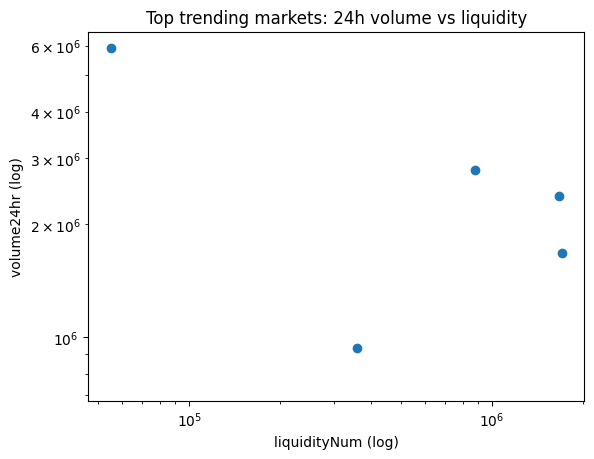

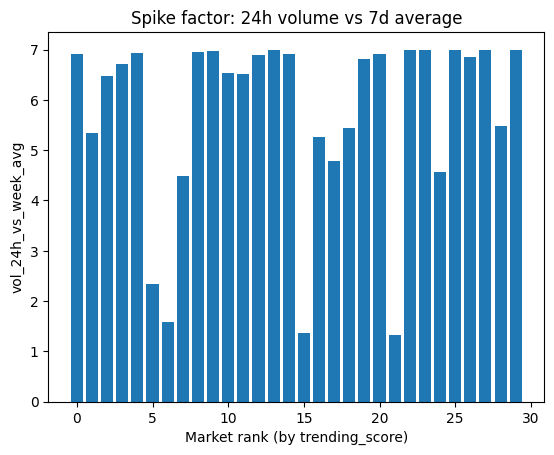

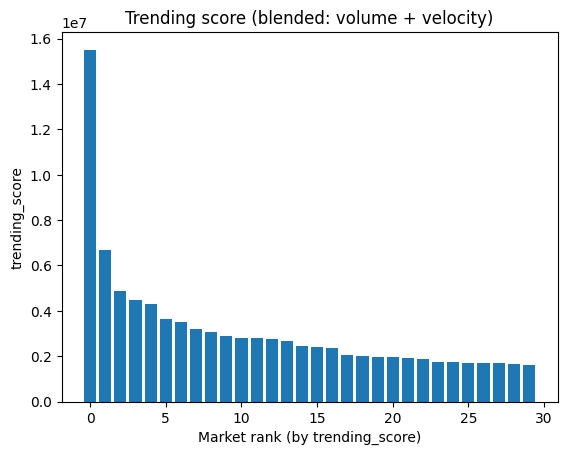

In [32]:
import matplotlib.pyplot as plt

TOP_N = 30
top = df.head(TOP_N).copy()

# 1) Volume24hr vs LiquidityNum (log scales help)
if "liquidityNum" in top.columns and "volume24hr" in top.columns:
    plt.figure()
    plt.scatter(top["liquidityNum"], top["volume24hr"])
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("liquidityNum (log)")
    plt.ylabel("volume24hr (log)")
    plt.title("Top trending markets: 24h volume vs liquidity")
    for _, r in top.iterrows():
        # label lightly; too many labels can clutter
        pass
    plt.show()

# 2) Velocity ratio (24h vs weekly avg)
if "vol_24h_vs_week_avg" in top.columns:
    plt.figure()
    plt.bar(range(len(top)), top["vol_24h_vs_week_avg"].fillna(0).values)
    plt.xlabel("Market rank (by trending_score)")
    plt.ylabel("vol_24h_vs_week_avg")
    plt.title("Spike factor: 24h volume vs 7d average")
    plt.show()

# 3) Trending score
plt.figure()
plt.bar(range(len(top)), top["trending_score"].values)
plt.xlabel("Market rank (by trending_score)")
plt.ylabel("trending_score")
plt.title("Trending score (blended: volume + velocity)")
plt.show()

In [ ]:
import requests
import pandas as pd
import numpy as np

GAMMA_BASE = "https://gamma-api.polymarket.com"

def fetch_markets(
    *,
    max_markets: int = 500,
    page_limit: int = 200,
    order: str = "volume24hr",
    ascending: bool = False,
    timeout_s: float = 30.0,
) -> list[dict]:
    """
    Fetch up to `max_markets` market rows from Gamma /markets.
    No filtering (restricted/non-restricted not considered).
    """
    out: list[dict] = []
    offset = 0

    while len(out) < max_markets:
        lim = min(page_limit, max_markets - len(out))
        params = {
            "limit": lim,
            "offset": offset,
            "order": order,
            "ascending": str(ascending).lower(),
        }

        r = requests.get(f"{GAMMA_BASE}/markets", params=params, timeout=timeout_s)
        r.raise_for_status()
        batch = r.json()

        if not isinstance(batch, list) or not batch:
            break

        out.extend(batch)

        # stop if API returns fewer than we asked for (end of list)
        if len(batch) < lim:
            break

        offset += lim

    return out



def filter_markets_by_thresholds(
    markets: list[dict],
    *,
    max_spread: float = 0.03,          # 2–3¢ => 0.02–0.03
    min_liquidity_clob: float = 30_000,
    min_volume24h: float = 50_000,     # set to 100_000 for stricter
    require_live: bool = True,         # recommended: ignore closed/archived
) -> pd.DataFrame:
    """
    Filter markets by:
      1) spread <= max_spread
      2) liquidityClob (fallback liquidityNum/liquidity) >= min_liquidity_clob
      3) 24h volume (prefer volume24hrClob fallback volume24hr) >= min_volume24h
    Returns ONLY markets that pass.
    """
    df = pd.json_normalize(markets)

    def num(col: str) -> pd.Series:
        if col in df.columns:
            return pd.to_numeric(df[col], errors="coerce")
        return pd.Series(np.nan, index=df.index)

    # --- canonical 24h volume (prefer CLOB) ---
    vol24h_clob = num("volume24hrClob")
    vol24h_raw = num("volume24hr")
    df["volume24h_canon"] = vol24h_clob.where(vol24h_clob.notna(), vol24h_raw).fillna(0)

    # --- canonical liquidity (prefer liquidityClob) ---
    liq_clob = num("liquidityClob")
    liq_num = num("liquidityNum")
    liq_raw = num("liquidity")
    df["liquidity_canon"] = (
        liq_clob.where(liq_clob.notna(), liq_num)
               .where(lambda x: x.notna(), liq_raw)
               .fillna(0)
    )

    # --- bid/ask + spread ---
    df["bestBid"] = num("bestBid")
    df["bestAsk"] = num("bestAsk")
    spread = num("spread")

    spread_calc = spread.where(spread.notna(), df["bestAsk"] - df["bestBid"])
    spread_calc = spread_calc.where(df["bestBid"].notna() & df["bestAsk"].notna(), np.nan)
    df["spread_calc"] = spread_calc

    # --- live-only filter (optional but recommended) ---
    if require_live:
        active = df["active"].fillna(True) if "active" in df.columns else True
        closed = df["closed"].fillna(False) if "closed" in df.columns else False
        archived = df["archived"].fillna(False) if "archived" in df.columns else False
        accepting = df["acceptingOrders"].fillna(True) if "acceptingOrders" in df.columns else True
        live_mask = (active == True) & (closed == False) & (archived == False) & (accepting == True)
    else:
        live_mask = pd.Series(True, index=df.index)

    # --- your 3 thresholds ---
    mask = (
        live_mask
        & df["spread_calc"].notna()
        & (df["spread_calc"] <= max_spread)
        & (df["liquidity_canon"] >= min_liquidity_clob)
        & (df["volume24h_canon"] >= min_volume24h)
    )

    keep = [c for c in [
        "id","slug","question","category",
        "active","closed","archived","acceptingOrders",
        "bestBid","bestAsk","spread","spread_calc",
        "liquidityClob","liquidityNum","liquidity","liquidity_canon",
        "volume24hrClob","volume24hr","volume24h_canon",
    ] if c in df.columns]

    # computed columns always exist
    for c in ["bestBid","bestAsk","spread_calc","liquidity_canon","volume24h_canon"]:
        if c not in keep:
            keep.append(c)

    out = df.loc[mask, keep].copy()
    out = out.sort_values(["volume24h_canon", "liquidity_canon", "spread_calc"], ascending=[False, False, True])
    return out


# -------------------------
# Example call (copy/paste)
# -------------------------
raw = fetch_markets(max_markets=500, order="volume24hr", ascending=False)

filtered = filter_markets_by_thresholds(
    raw,
    max_spread=0.03,           # 3¢ (set 0.02 for stricter)
    min_liquidity_clob=30_000,
    min_volume24h=50_000,      # set 100_000 for stricter
    require_live=True,
)

print("Markets pulled:", len(raw))
print("Markets passing thresholds:", len(filtered))
print(filtered.head(25).to_string(index=False))

Markets pulled: 500
Markets passing thresholds: 115
     id                                                                                                                                                        slug                                                                              question  active  closed  archived  acceptingOrders  bestBid  bestAsk  spread  spread_calc  liquidityClob  liquidityNum     liquidity  liquidity_canon  volume24hrClob   volume24hr  volume24h_canon
 654415                                                                                 will-the-fed-increase-interest-rates-by-25-bps-after-the-march-2026-meeting         Will the Fed increase interest rates by 25+ bps after the March 2026 meeting?    True   False     False             True    0.006    0.007   0.001        0.001   1.777030e+06  1.777030e+06 1777030.05394     1.777030e+06    3.502702e+06 3.502702e+06     3.502702e+06
 654412                                                                 